In [1]:
import os
from pathlib import Path
import sys

sys.path.append(str(Path(os.path.abspath('')).parent))

In [2]:
from src.data.cifar100 import Cifar100
from src.models.baseline import Baseline

In [3]:
from pprint import pprint

# load cifar100
def load_cifar100():
    cifar100 = Cifar100()
    dataloaders = cifar100.load_branch_dataloaders()
    return dataloaders

cifar_branch_dataloaders = load_cifar100()
pprint(cifar_branch_dataloaders)

defaultdict(<class 'dict'>,
            {'aquatic_mammals': {'test': <torch.utils.data.dataloader.DataLoader object at 0x7fe7948dc6d0>,
                                 'train': <torch.utils.data.dataloader.DataLoader object at 0x7fe7948dc5e0>},
             'fish': {'test': <torch.utils.data.dataloader.DataLoader object at 0x7fe7947f9070>,
                      'train': <torch.utils.data.dataloader.DataLoader object at 0x7fe7948dcf40>},
             'flowers': {'test': <torch.utils.data.dataloader.DataLoader object at 0x7fe7948dcc70>,
                         'train': <torch.utils.data.dataloader.DataLoader object at 0x7fe7948dcb80>},
             'food_containers': {'test': <torch.utils.data.dataloader.DataLoader object at 0x7fe7947f9610>,
                                 'train': <torch.utils.data.dataloader.DataLoader object at 0x7fe7947f9520>},
             'fruit_and_vegetables': {'test': <torch.utils.data.dataloader.DataLoader object at 0x7fe7948dc310>,
                         

In [4]:
# load baseline model
def load_baseline(branch_dataloaders: dict):
    resnet_layers = [1,1,1,1]
    model = Baseline(stem_layers=resnet_layers)

    stem_out_size = model.stem.get_output_size(input_size=(16, 3, 32, 32))

    branch_configs = dict()
    for branch_name, branch_dataloader in branch_dataloaders.items():
        branch_configs[branch_name] = tuple(
            (stem_out_size, len(branch_dataloader['train'].dataset.classes))
        )

    model.initialize_branches(branch_configs=branch_configs)
    return model

baseline = load_baseline(branch_dataloaders=cifar_branch_dataloaders)
baseline.print_model_summary(input_size=(16, 3, 32, 32))

Printing model summary
Layer (type:depth-idx)                             Output Shape              Param #
Baseline                                           --                        --
├─Stem: 1-1                                        [16, 512]                 --
│    └─ResNet: 2-1                                 [16, 512]                 --
│    │    └─Conv2d: 3-1                            [16, 64, 16, 16]          9,408
│    │    └─BatchNorm2d: 3-2                       [16, 64, 16, 16]          128
│    │    └─ReLU: 3-3                              [16, 64, 16, 16]          --
│    │    └─MaxPool2d: 3-4                         [16, 64, 8, 8]            --
│    │    └─Sequential: 3-5                        [16, 64, 8, 8]            73,984
│    │    └─Sequential: 3-6                        [16, 128, 4, 4]           230,144
│    │    └─Sequential: 3-7                        [16, 256, 2, 2]           919,040
│    │    └─Sequential: 3-8                        [16, 512, 1, 1]        

In [5]:
# implement a forward pass through the baseline
for branch_name, branch_dataloaders in cifar_branch_dataloaders.items():
    print(f'Loaded dataloaders for branch: {branch_name}')

    train_features, train_labels = next(iter(branch_dataloaders['train']))
    
    print(f'Features shape: {train_features.shape}')
    print(f'Labels shape: {train_labels.shape}')

    # get output from a single branch
    out = baseline(train_features, branch_name)
    print(f'Output shape from single branch: {out.shape}')

    # get output from all branches
    out = baseline(train_features)
    print(f'Output shape from all branches: {out.shape}')

    break

Loaded dataloaders for branch: people
Features shape: torch.Size([16, 3, 32, 32])
Labels shape: torch.Size([16])
Output shape from single branch: torch.Size([16, 5])
Output shape from all branches: torch.Size([16, 100])


In [6]:
branches = list(cifar_branch_dataloaders.keys())

train_loaders = []
test_loaders = []
for branch in branches:
    train_test_dataloaders = cifar_branch_dataloaders[branch]

    train_loader = train_test_dataloaders['train']
    test_loader = train_test_dataloaders['test']

    # train_loaders.append((branch, train_loader))
    # test_loaders.append((branch, test_loader))
    train_loaders.append(train_loader)
    test_loaders.append(test_loader)

print(type(train_loaders), len(train_loaders))
print(train_loaders[0])

<class 'list'> 20


people


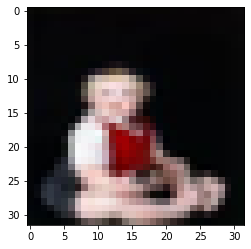

In [7]:
import numpy as np
import matplotlib.pyplot as plt

for i, data in enumerate(zip(*train_loaders)):
    for branch_name, branch_batch in zip(branches, data):
        print(branch_name)

        images, labels = branch_batch
        img = images[0].cpu().detach().numpy()
        img = np.moveaxis(img, 0, -1)
        plt.figure()
        plt.imshow(img, cmap='gray')
        break
    if i == 0:
        break

In [8]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(baseline.parameters(), lr=0.0005, momentum=0.9)

In [9]:
for epoch in range(2):

    for i, data in enumerate(zip(*train_loaders)):
        running_loss = 0.0
        for branch_num, (branch_name, branch_batch) in enumerate(zip(branches, data)):

            images, labels = branch_batch
            optimizer.zero_grad()

            # forward
            outputs = baseline(images, branch_name)

            # backward
            loss = criterion(outputs, labels)
            loss.backward()

            # optimize
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            # if branch_num == 19:
            #     print('Went through all branches')

        print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss:.3f}')
        running_loss = 0.0

print('Finished training')

Epoch: 1, Batch: 1, Loss: 32.759
Epoch: 1, Batch: 2, Loss: 32.187
Epoch: 1, Batch: 3, Loss: 32.424
Epoch: 1, Batch: 4, Loss: 32.574
Epoch: 1, Batch: 5, Loss: 32.489
Epoch: 1, Batch: 6, Loss: 32.268
Epoch: 1, Batch: 7, Loss: 32.166
Epoch: 1, Batch: 8, Loss: 32.555
Epoch: 1, Batch: 9, Loss: 32.083
Epoch: 1, Batch: 10, Loss: 32.509
Epoch: 1, Batch: 11, Loss: 31.825
Epoch: 1, Batch: 12, Loss: 31.997
Epoch: 1, Batch: 13, Loss: 32.127
Epoch: 1, Batch: 14, Loss: 31.508
Epoch: 1, Batch: 15, Loss: 31.659
Epoch: 1, Batch: 16, Loss: 31.318
Epoch: 1, Batch: 17, Loss: 31.442
Epoch: 1, Batch: 18, Loss: 31.541
Epoch: 1, Batch: 19, Loss: 31.453
Epoch: 1, Batch: 20, Loss: 31.335
Epoch: 1, Batch: 21, Loss: 31.562
Epoch: 1, Batch: 22, Loss: 31.302
Epoch: 1, Batch: 23, Loss: 31.177
Epoch: 1, Batch: 24, Loss: 31.266
Epoch: 1, Batch: 25, Loss: 31.450
Epoch: 1, Batch: 26, Loss: 30.898
Epoch: 1, Batch: 27, Loss: 30.972
Epoch: 1, Batch: 28, Loss: 31.045
Epoch: 1, Batch: 29, Loss: 31.159
Epoch: 1, Batch: 30, Lo

In [10]:
import torch

torch.save(baseline.state_dict(), os.path.join(Path(os.path.abspath('')).parent, 'models', 'baseline_trained_2_epochs_cifar100.pth'))